In [1]:
import pandas as pd
import os.path as osp
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from nltk import edit_distance
from torch import nn
from torchvision import models
from livelossplot import PlotLosses
from tqdm import tqdm
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

device = "cuda:1"

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

In [2]:
train_labels = pd.read_csv("train_labels.csv", sep=",")

In [3]:
cnt = defaultdict(int)
for line in train_labels["Expected"].values:
    if not isinstance(line, str):
        line = str(line)
    for char in line:
        char = char.lower()
        cnt[char] += 1
cnt = sorted(cnt.items(), key=lambda x: x[1], reverse=True)

bad_chars = set()
for k, v in cnt:
    if v < 500:
        if k not in bad_chars:
            bad_chars.add(k)

In [4]:
def filter_texts(text, bad_chars=bad_chars):
    if not isinstance(text, str):
        text = str(text)
    for ch in text:
        if ch in bad_chars:
            return False
    return True

In [5]:
train_labels["correct_data"] = train_labels["Expected"].apply(lambda x: filter_texts(x))
filtred_labels = train_labels[train_labels["correct_data"] == True].iloc[:, :-1]

In [6]:
filtred_labels

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз
2,3.jpg,ходят
3,4.jpg,"ощущений,"
4,5.jpg,74
...,...,...
275995,275996.jpg,DO
275996,275997.jpg,BASUCC
275997,275998.jpg,"1,120"
275998,275999.jpg,"наблюдателей,"


In [7]:
train, val = train_test_split(filtred_labels, shuffle=True, test_size=0.2, random_state=42)

In [8]:
char2idx = {"山":0}
abc = ["山"]
idx2char = {0: "山"}
cnt = 1
for line in filtred_labels["Expected"].values:
    if not isinstance(line, str):
        line = str(line)
    for ch in line:
        ch = ch.lower()
        if ch not in char2idx:
            abc.append(ch)
            char2idx[ch] = cnt
            idx2char[cnt] = ch
            cnt += 1

In [9]:
class RecognitionDataset(Dataset):

    def __init__(self, folder_path, df, char2idx, transforms=None):
        super(RecognitionDataset, self).__init__()
        self.folder_path = folder_path
        self.transforms = transforms
        self.df = df
        self.char2idx = char2idx

    def __len__(self):
        return self.df.shape[0]
    
    def __text_to_seq(self, text):
        if not isinstance(text, str):
            text = str(text)
        return [self.char2idx[ch.lower()] for ch in text]
        
    def __getitem__(self, idx):
        image_path = osp.join(self.folder_path, self.df.iloc[idx]["Id"])
#         image = Image.open(image_path).convert("RGB")
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image=img)["image"]
        
        text = self.df.iloc[idx]["Expected"]
        seq = self.__text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)

        return output

In [10]:
def collate_fn(batch):
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(item["image"])
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"images": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

## Dataloaders

Буду аугментировать данные согласно статье https://towardsdatascience.com/effective-data-augmentation-for-ocr-8013080aa9fa

In [11]:
aug = A.Compose([
                A.RandomRain(brightness_coefficient=1.0, drop_length=2, drop_width=2, 
                              drop_color = (0, 0, 0), blur_value=1, 
                              rain_type = 'drizzle', p=0.05),
                 A.RandomShadow(p=0.2),
                 A.PixelDropout(p=0.3),
                 A.ShiftScaleRotate(shift_limit=0, scale_limit=0.25, rotate_limit=2, 
                                    border_mode=cv2.BORDER_CONSTANT, value=(255,255,255), p=0.5),
                 A.Blur(blur_limit=5, p=0.25),
                ])

In [12]:
train_transforms = A.Compose([A.Resize(64, 320),
                              aug,
                              A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                              ToTensorV2()])

val_transforms = A.Compose([A.Resize(64, 320),
                              aug,
                              A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                              ToTensorV2()])


In [13]:
train_dataset = RecognitionDataset(folder_path="train/train", df=train, 
                                   char2idx=char2idx, transforms=train_transforms)

val_dataset = RecognitionDataset(folder_path="train/train", df=val, 
                                 char2idx=char2idx, transforms=train_transforms)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, 
                              collate_fn=collate_fn, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=True, 
                            collate_fn=collate_fn, num_workers=6)

## Model

In [15]:
max_ctc_len = 32
h, w = (64, 320)

In [16]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(h, w), output_len=max_ctc_len):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet34')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features


class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x


class CRNN(nn.Module):
    
    def __init__(self, alphabet=len(idx2char),
                 cnn_input_size=(h, w), cnn_output_len=max_ctc_len,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=alphabet, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence


In [17]:
def pred_to_string(pred, idx2char=idx2char):
    seq = []
    for i in range(len(pred)):
        seq.append(np.argmax(pred[i]))
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != 0:
                out.append(seq[i])
        else:
            if seq[i] != 0 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = "".join([idx2char[c] for c in out])
    return out

def decode(pred, idx2char=idx2char):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], idx2char))
    return outputs

In [18]:
class EarlyStopping:
    def __init__(self, track_metric_extreme=float("inf"), patience=7):
        self.track_metric_extreme = track_metric_extreme
        self.cnt = 0
        self.patience = patience
        self.early_stop = False

    def __call__(self, track_metric):
        if track_metric < self.track_metric_extreme:
            self.track_metric_extreme = track_metric
            self.cnt = 0
        else:
            self.cnt += 1
            if self.cnt == self.patience:
                self.early_stop = True

In [19]:
device = "cuda:1"
model = CRNN()
# model.features_extractor.cnn.load_state_dict(torch.load("resnet34_cnn.pth", map_location=device))
model.to(device);

In [20]:
criterion = nn.CTCLoss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5)
epoch_num = 50
early_stopping = EarlyStopping()

In [21]:
def get_edit_dist(decoded_texts, gt_texts):
    res = 0
    for dec, gt in zip(decoded_texts, gt_texts):
        if not isinstance(dec, str):
            dec = str(dec)
        if not isinstance(gt, str):
            gt = str(gt)
        res += edit_distance(dec, gt)
    res /= len(decoded_texts)
    return res

In [22]:
def train(model,
          criterion,
          optimizer,
          scheduler,
          train_loader,
          val_loader, 
          epoch_num,
          experiment_name,
          early_stopping,):

    valid_loss = 0
    plotter = PlotLosses()
    min_cer = float("inf")
    
    for epoch in range(epoch_num):
        model.train()
        batch_loss = 0
        batch_cer = 0
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            img, seq = batch["images"], batch["seq"]
            img = img.to(device)
            logits = model(img)
            preds = logits.log_softmax(2)
            predicted_text = decode(logits)
            seq_lens_pred = torch.Tensor([preds.size(0)] * preds.size(1)).int()
            
            loss = criterion(preds, seq, seq_lens_pred, batch["seq_len"])
            batch_loss += loss.item()
            
            batch_cer += get_edit_dist(predicted_text, batch["text"])
            
            loss.backward()
            optimizer.step()


            with open(f"{experiment_name}.log", "a") as f:
                for line in predicted_text[:10]:
                    f.write(f"train_dec: {line}\n")

            if idx % 20 == 19:
                plotter.update({"train_loss": batch_loss / (idx + 1),
                               "train_cer": batch_cer / (idx + 1)})
                plotter.send()
        
        train_loss = batch_loss / len(train_loader)
        train_cer = batch_cer / len(train_loader)
        
        with open(f"{experiment_name}_training.log", "a") as f:
            f.write(f"Epoch {epoch} train_loss={round(train_loss, 4)} train_cer={round(train_cer, 4)}")
        
        with torch.no_grad():
            model.eval()
            batch_loss = 0
            batch_cer = 0
            
            for idx, batch in enumerate(val_loader):
                
                img, seq = batch["images"], batch["seq"]
                img = img.to(device)
                
                logits = model(img)
                preds = logits.log_softmax(2)
                predicted_text = decode(logits)
                seq_lens_pred = torch.Tensor([preds.size(0)] * preds.size(1)).int()
            
                loss = criterion(preds, seq, seq_lens_pred, batch["seq_len"])

                batch_loss += loss.item()
                batch_cer += get_edit_dist(predicted_text, batch["text"])
                
                with open(f"{experiment_name}.log", "a") as f:
                    for line in predicted_text[:10]:
                        f.write(f"val_dec: {line}\n")

            mean_cer = batch_cer / len(val_loader)
            valid_loss = batch_loss / len(val_loader)
            scheduler.step(valid_loss)
        
            with open(f"{experiment_name}_training.log", "a") as f:
                 f.write(f"val_loss={round(valid_loss, 4)} val_cer={round(mean_cer, 4)}\n")
            
            if mean_cer < min_cer:
                torch.save(model.state_dict(), f"weights/{experiment_name}.pth")
                min_cer = mean_cer

            plotter.update({"val_loss": valid_loss, "val_cer": mean_cer})
            plotter.send()

            early_stopping(track_metric=valid_loss)
            if early_stopping.early_stop:
                print(f"Early stop on {epoch} epoch")
                break

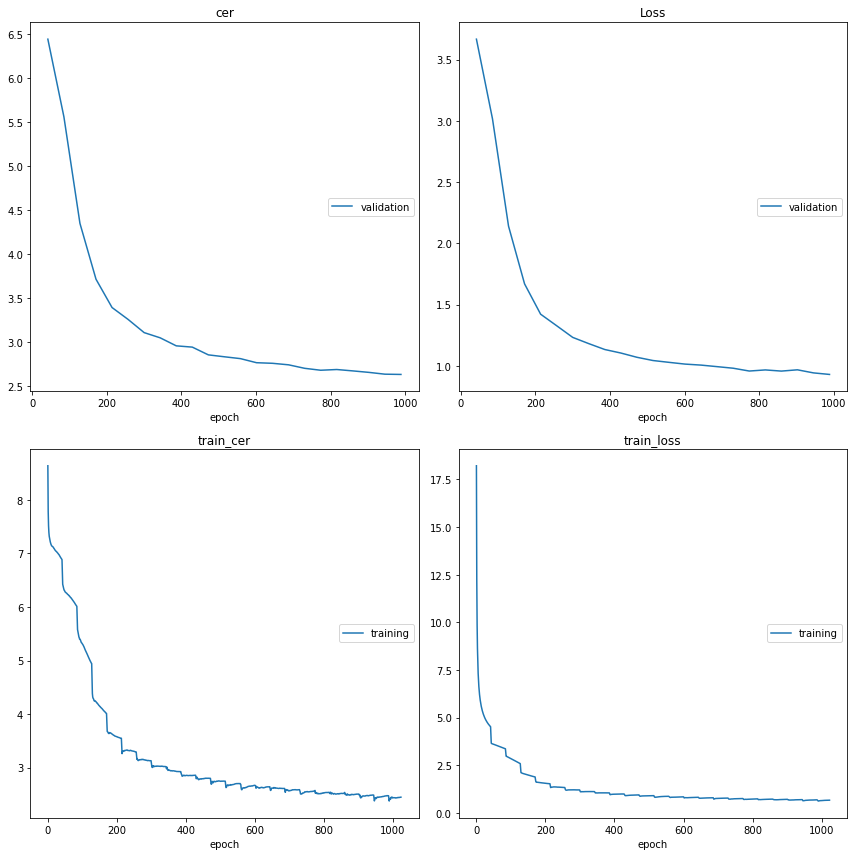

cer
	validation       	 (min:    2.633, max:    6.442, cur:    2.633)
Loss
	validation       	 (min:    0.930, max:    3.667, cur:    0.930)
train_cer
	training         	 (min:    2.375, max:    8.637, cur:    2.447)
train_loss
	training         	 (min:    0.624, max:   18.220, cur:    0.669)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
train(model=model,
      criterion=criterion,
      optimizer=optimizer,
      scheduler=scheduler,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      epoch_num=epoch_num,
      experiment_name="resnet34_alb",
      early_stopping=early_stopping)

In [25]:
model.load_state_dict(torch.load("weights/resnet34_alb.pth"))

<All keys matched successfully>

In [41]:
def collate_fn_test(batch):
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(item["images"].float())
    images = torch.stack(images)
    batch = {"images": images}
    return batch

def pred_image(image_path, device):
    image = Image.open(image_path)
    image_tensor = test_transforms(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    preds = model(image_tensor).cpu().detach()
    texts_pred = decode(preds)
    return texts_pred[0]


test_transforms = T.Compose([T.Resize((64, 320)),
                             T.ToTensor(),
                             T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
                                      

test = pd.read_csv("sample_submission.csv", sep=",")
test_dataset = RecognitionDataset(folder_path="test/test", df=test, 
                                 char2idx=char2idx, transforms=test_transforms)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn_test, num_workers=6)

model.eval()
sample_submission = pd.read_csv("sample_submission.csv")
counter = 0
for row in tqdm(sample_submission.iterrows()):
    filename = row[1]["Id"]
    text = pred_image(osp.join("test/test", filename), device)
    row[1]["Predicted"] = text

sample_submission.to_csv("result_resnet34_alb.csv", index=False)

file = "5.jpg"
img = Image.open(f"test/test/{file}")
img

sample_submission[sample_submission["Id"] == file]

In [42]:
test_transforms = T.Compose([T.Resize((64, 320)),
                             T.ToTensor(),
                             T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
                                      

# test_dataset = CaptchaDataset(ROOT, "sample_submission.csv", label2idx, False, test_transforms)
test = pd.read_csv("sample_submission.csv", sep=",")
test_dataset = RecognitionDataset(folder_path="test/test", df=test, 
                                 char2idx=char2idx, transforms=test_transforms)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn_test, num_workers=6)

In [44]:
model.eval()
sample_submission = pd.read_csv("sample_submission.csv")
counter = 0
for row in tqdm(sample_submission.iterrows()):
    filename = row[1]["Id"]
    text = pred_image(osp.join("test/test", filename), device)
    row[1]["Predicted"] = text

sample_submission.to_csv("result_resnet34_alb.csv", index=False)

52999it [06:44, 131.04it/s]


In [51]:
file = "5.jpg"
img = Image.open(f"test/test/{file}")
img

In [52]:
sample_submission[sample_submission["Id"] == file]

,Id,Predicted
4,5.jpg,bao
